In [1]:
import torch
import numpy
import sys

sys.path.append('../')
sys.path.append('../model')

In [2]:
from classifiers import EncoderClassifier, EncoderClassifierConfig
from training import run_training, LightningWrapper
from encoder import create_model, add_arguments
from esm_train import get_esm, device, parser
from data_loading import prepare_datasets
from torchmetrics import F1Score, MatthewsCorrCoef, Precision, Recall, AUROC, \
MeanMetric, AveragePrecision, PrecisionRecallCurve, MetricCollection
from torch.utils.data import DataLoader
from functools import partial
from data_loading import prep_batch

/storage/praha1/home/nexuso1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
chkpt_path = '../model/new_logs/encoder_S_60_focal/fold_0/chkpt.ckpt'
checkpoint = torch.load(chkpt_path)
args = parser.parse_args(args=[])

for k, v in checkpoint['hyper_parameters'].items():
    args.__setattr__(k, v)

model, tokenizer = create_model(args)
# Fix potential dictionary issues with checkpoint keys
prefix = 'classifier.'
for k in list(checkpoint['state_dict'].keys()):
    checkpoint['state_dict'][k.removeprefix(prefix)] = checkpoint['state_dict'].pop(k)
model.load_state_dict(checkpoint['state_dict'])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EncoderClassifier(
  (base): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, element

<All keys matched successfully>

In [4]:
model.to(device)

EncoderClassifier(
  (base): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, element

In [5]:
full_dataset = prepare_datasets(args, ignore_label=args.ignore_label)

step_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
})

epoch_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
    'auroc' : AUROC('binary', ignore_index=args.ignore_label),
    'auprc' : AveragePrecision('binary', ignore_index=args.ignore_label),
    'mcc' : MatthewsCorrCoef('binary', ignore_index=args.ignore_label)
})

In [6]:
train_ds, dev_ds, test_ds = full_dataset.get_fold(0)
train = DataLoader(train_ds, args.batch_size, shuffle=True,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False, 
                    num_workers=args.num_workers )
dev = DataLoader(dev_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

test = DataLoader(test_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

Train size: 7180
Dev size: 1796
Test size: 2244


In [7]:
class OutputGatherModule(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
        self.last_batch = None
        
    def forward(self, *args, **kwargs):
        out = self.module(*args, **kwargs)
        self.last_batch = out
        return out
    

In [8]:
model.encoder = OutputGatherModule(model.encoder)

In [9]:
embed_df = {}
all_embeds = []
with torch.no_grad():
    for batch in test:
        loss, batch_preds = model.predict(**batch.to(model.device))
        batch_labels = batch['labels']
        embeds = model.encoder.last_batch
        mask = batch_labels != model.ignore_index
        ids = test_ds.data.iloc[batch['indices'].cpu().numpy()]['id']

        # Save the predictions
        for i, id in enumerate(ids):
            embed_df[id] = {}
            embed_df[id]['prot_embed'] = embeds[i][0].cpu().numpy()
            embed_df[id]['embeds'] = embeds[i][1:][mask[i]].cpu().numpy()
            all_embeds.extend(embed_df[id]['embeds'].tolist())
            embed_df[id]['mask'] = mask[i].cpu().numpy()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


In [10]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [11]:
tsne = TSNE(n_jobs=15, random_state=42)

In [12]:
embed_df = pd.DataFrame.from_dict(embed_df, orient='index')

In [13]:
all_embeds = np.asarray(all_embeds)

In [14]:
transformed = tsne.fit_transform(all_embeds)

In [15]:
import matplotlib.pyplot as plt

In [16]:
transformed.shape

(91153, 2)

Text(0.5, 1.0, 'Test set Serine embeddings')

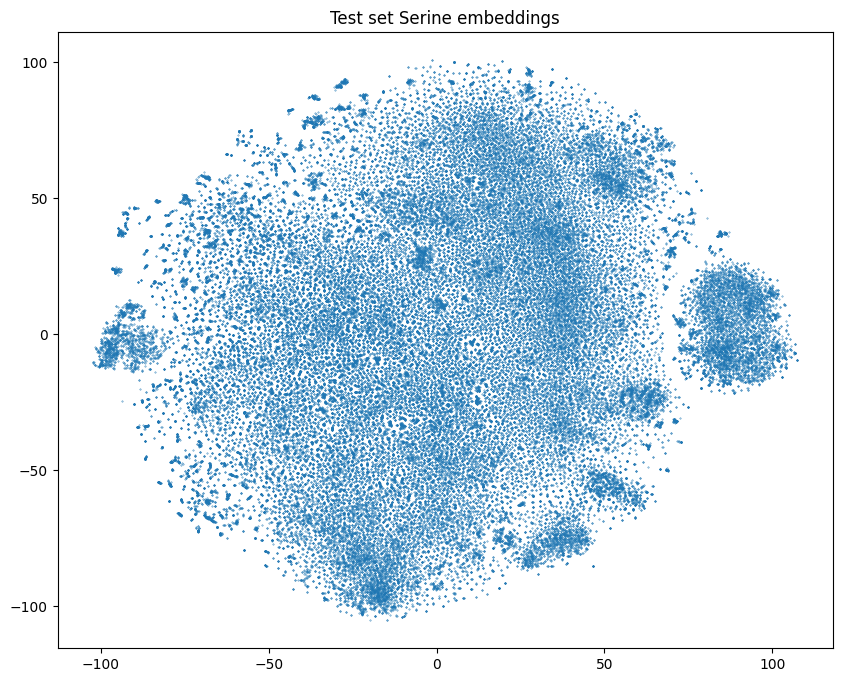

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(transformed[:, 0], transformed[:, 1], s=0.1)
plt.title('Test set Serine embeddings')

In [18]:
labels = []
families = []

In [51]:
kinase_info = pd.read_json('../data/prots_with_kinase_preds.json')

In [52]:
kinase_info.head(5)

,id,sites,sequence,kinase_preds
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,"{'Name': ['GAK', 'GSK3B', 'IKKA'], 'Family': [..."
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,"{'Name': ['MAPKAPK5', 'FGR', 'BIKE', 'ALPHAK3'..."
2,A0A087WP46,"[359, 972, 973, 974, 988, 997, 1000, 1005, 101...",MARDGAEQPDSGPLPRPSPCPQEDRASNLMPPKPPRTWGLQLQGPS...,"{'Name': ['PRP4', 'YANK3', 'FAK', 'PRPK', 'BUB..."
3,A0A087WPF7,"[32, 43, 622, 626, 798, 941, 956, 1031, 1038, ...",MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,"{'Name': ['LKB1', 'HASPIN', 'GSK3B', 'NEK11', ..."
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...,"{'Name': ['PDGFRA'], 'Family': ['PDGFR'], 'Sco..."


In [53]:
kinase_info = kinase_info.set_index('id')

In [54]:
embed_df['sites'] = kinase_info['sites'].apply(lambda x: [int(i) for i in x]) # sites are strings
embed_df['kinase_preds'] = kinase_info['kinase_preds']

In [55]:
embed_df.head(5)

,prot_embed,embeds,mask,sites,kinase_preds
A0A024R4G9,"[-1.5486466, 0.24810646, -3.0108247, 0.7865669...","[[-1.3977635, 0.14299665, -2.5633352, 0.337363...","[False, False, False, False, False, False, Fal...","[14, 16, 20]","{'Name': ['GAK', 'GSK3B', 'IKKA'], 'Family': [..."
A0A087WQP5,"[-1.2748679, -0.06752821, -2.4625783, 0.167449...","[[-0.8683373, -0.7252959, -1.1595052, 1.265658...","[False, False, False, False, False, False, Fal...","[98, 102, 107]","{'Name': ['GSK3B', 'CK1A2', 'TAO3'], 'Family':..."
A0A0R4J0D1,"[-1.2820783, -0.5590232, -2.074907, 0.58160526...","[[-0.70015496, -0.4237716, -0.1876812, 0.63865...","[False, False, False, False, True, False, Fals...","[25, 28, 351, 355]","{'Name': ['GSK3B', 'CK1A', 'GSK3B', 'CK1A2'], ..."
A0PJX2,"[-1.8151474, 0.43069583, -2.8337934, 1.079829,...","[[0.7477731, -0.0935747, -0.63377535, 0.322229...","[False, False, False, False, False, False, Fal...","[153, 155]","{'Name': ['PDHK4', 'MEKK3'], 'Family': ['PDHK'..."
A1IGU4,"[-1.4405522, -0.20566098, -1.534137, -0.254033...","[[0.88990533, -0.9346723, 0.7470177, 0.1561101...","[False, False, False, False, False, False, Fal...",[201],"{'Name': ['PRKD1'], 'Family': ['CAMK'], 'Score..."


In [56]:
labels = []
families = []
for id in embed_df.index:
    row = embed_df.loc[id]
    indices = np.nonzero(row['mask'])[0]
    tp_mask = [i in row['sites'] for i in indices]
    # Duplicated sites for some reason
    if np.asarray(tp_mask).sum() != len(row['kinase_preds']['Family']):
        print(id)
        print(tp_mask)
        print(indices)
        print(row['sites'])
        print(row['kinase_preds']['Family'])
        r_fams = row['kinase_preds']['Family'] 
        row['kinase_preds']['Family'] = r_fams[:len(r_fams) // 2] 
        print(row['kinase_preds']['Family'])
    labels.extend(tp_mask)
    families.extend(row['kinase_preds']['Family'])
    

P62806
[False, True, True, True, True, True]
[ 1 47 51 72 80 88]
[47, 51, 72, 80, 88, 47, 51, 72, 80, 88]
['AGC', 'FRK', 'TEC', 'AGC', 'PDGFR', 'AGC', 'FRK', 'TEC', 'AGC', 'PDGFR']
['AGC', 'FRK', 'TEC', 'AGC', 'PDGFR']


In [25]:
tp = transformed[labels]
tn = transformed[np.logical_not(labels)]

Text(0.5, 1.0, 'Test set (fold 0) Serine t-SNE encoder embeddings')

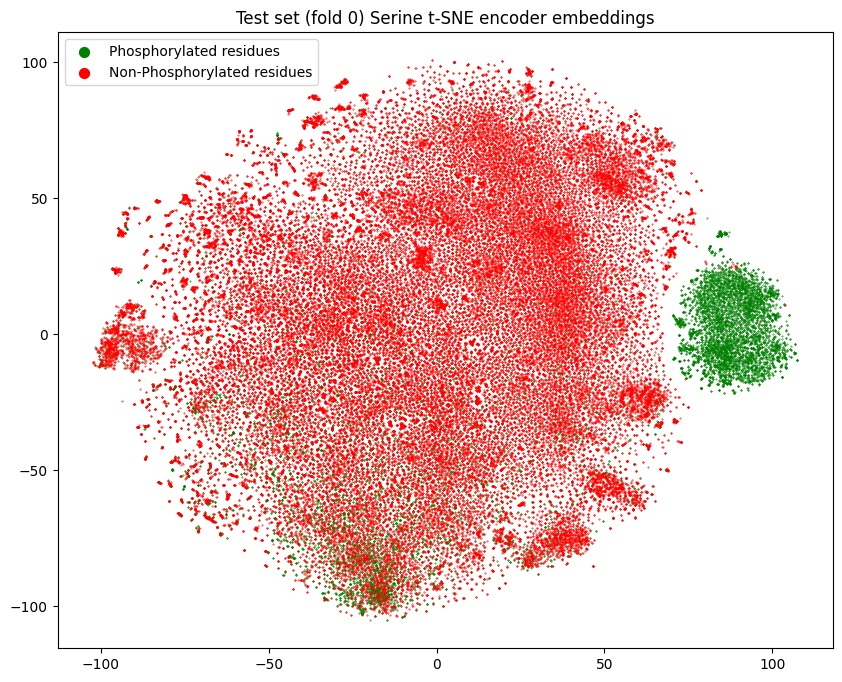

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(tp[:, 0], tp[:, 1], s=0.5, label='Phosphorylated residues', color='green', marker='.')
plt.scatter(tn[:, 0], tn[:, 1], s=0.5, label='Non-Phosphorylated residues', color='red', marker='.')
plt.legend(markerscale=20)
plt.title('Test set (fold 0) Serine t-SNE encoder embeddings')

In [27]:
unique_fams = np.unique(families)

In [28]:
fam_to_num = {unique_fams[i] : i for i in range(len(unique_fams))}

In [58]:
fam_labels = np.asarray([fam_to_num[f] for f in families])

In [67]:
from matplotlib import colormaps


In [71]:
cmap = colormaps['gist_rainbow']

In [74]:
np.linspace(0,1,len(unique_fams))

array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
       0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
       0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ,
       0.42857143, 0.45714286, 0.48571429, 0.51428571, 0.54285714,
       0.57142857, 0.6       , 0.62857143, 0.65714286, 0.68571429,
       0.71428571, 0.74285714, 0.77142857, 0.8       , 0.82857143,
       0.85714286, 0.88571429, 0.91428571, 0.94285714, 0.97142857,
       1.        ])

In [72]:
colors = cmap(np.linspace(0,1,len(unique_fams)))


In [80]:
colors[..., -1] = 0.3

In [193]:
def create_families_plot(tp, families, name : str):
    unique_fams = np.unique(families)
    fam_to_num = {unique_fams[i] : i for i in range(len(unique_fams))}
    fam_labels = np.asarray([fam_to_num[f] for f in families])
    cmap = colormaps['gist_rainbow']
    colors = cmap(np.linspace(0,1,len(unique_fams)))
    colors[..., -1] = 0.5 # Set alpha
    fig, ax = plt.subplots()
    fig.set_size_inches((9, 6))
    for i,fam in enumerate(fam_to_num.keys()): 
        mask = fam_labels == fam_to_num[fam]
        fam_embeds = tp[mask]
        ax.scatter(fam_embeds[:, 0], fam_embeds[:, 1], label=fam, marker='.', s=2, color=colors[i])
    ax.legend(markerscale=10, ncols=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('Phoshporylated residues families t-SNE plot')
    fig.tight_layout()
    plt.show()

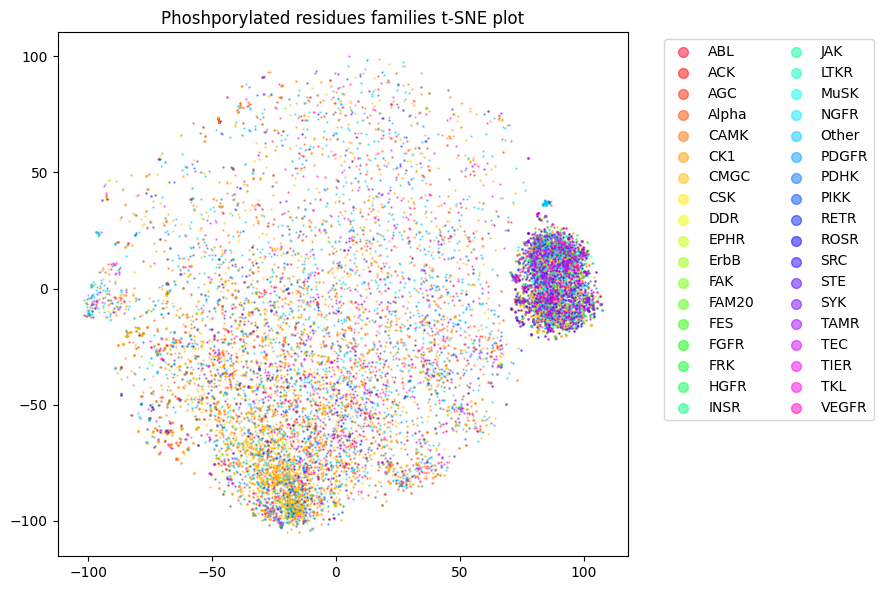

In [194]:
create_families_plot(tp, families, 'test')

In [114]:
import seaborn as sns

In [141]:
def density_plot(data, title=None):
    df = pd.DataFrame(data)
    fig, ax = plt.subplots()
    ax = sns.kdeplot(
    data=df, x=0, y=1,fill=True, thresh=0, levels=100, cmap="mako")
    ax.set_title(title)

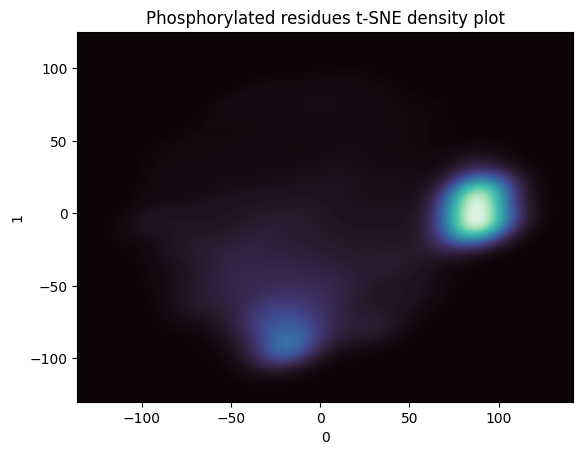

In [142]:
density_plot(tp, 'Phosphorylated residues t-SNE density plot')

In [145]:
kinase_info['relative_pos_sites'] = kinase_info.apply(lambda row: [int(x) / len(row['sequence']) for x in row['sites']], axis=1)

In [149]:
position_labels = []
for id in embed_df.index:
    mask = embed_df.loc[id]['mask']
    pos_labels = kinase_info.loc[id]['relative_pos_sites']
    # Duplicated sites
    if len(np.nonzero(mask)[0]) < len(pos_labels):
        pos_labels = pos_labels[:len(pos_labels) // 2]
        
    position_labels.extend(pos_labels)
    

In [150]:
len(position_labels)

16097

In [195]:
def create_positional_plot(tp_embeds, pos_labels):
    fig, ax = plt.subplots()
    cmap = colormaps['plasma']
    colors = cmap(pos_labels)
    colors[..., -1] = 0.7
    fig.set_size_inches((8, 6))
    ax.scatter(tp_embeds[:, 0], tp_embeds[:, 1], color=colors, marker='.', s=2)
    ax.set_title('Residue sequential position t-SNE plot')
    sm = plt.cm.ScalarMappable(cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Residue position / sequence length')
    
    return fig, ax

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Residue sequential position t-SNE plot'}>)

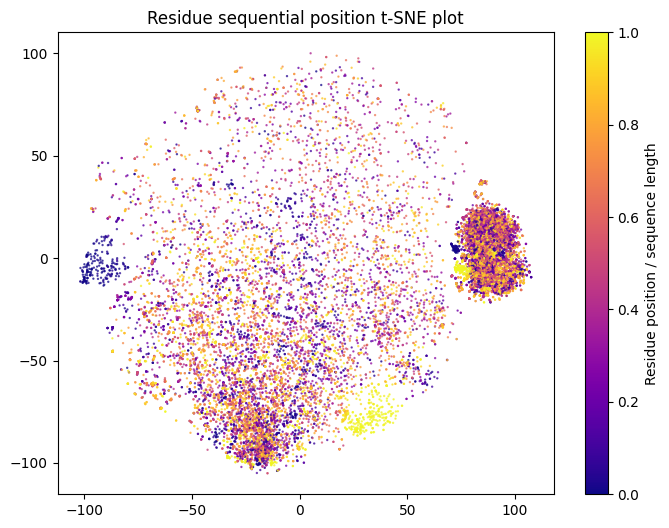

In [196]:
create_positional_plot(tp, position_labels)